In [33]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from policy import PolicyNN
from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [34]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
print(df_all.shape)
print(df_all.columns.tolist())

(610615, 12)
['time_index', 'melt_pool_temperature', 'melt_pool_depth', 'scanning_speed', 'X', 'Y', 'Z', 'Dist_to_nearest_X', 'Dist_to_nearest_Y', 'Dist_to_nearest_Z', 'Laser_power', 'laser_power_number']


In [35]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


[np.float64(0.0), np.float64(0.75), np.float64(0.8678160668808631), np.float64(1.1358663262803783), np.float64(1.403916585679894), np.float64(1.5), np.float64(1.5211383161901857), np.float64(1.789188575589701), np.float64(2.0572388349892163), np.float64(2.25), np.float64(2.442510824899036), np.float64(2.710561084298586), np.float64(2.978611343698029), np.float64(3.0), np.float64(3.095833074208392), np.float64(3.3638833336079417), np.float64(3.631933593007492), np.float64(3.75), np.float64(4.017205957917313), np.float64(4.285256217316901), np.float64(4.5), np.float64(4.670527682226559), np.float64(4.938577941626146), np.float64(5.206628201025734), np.float64(5.25), np.float64(5.323850156536165), np.float64(5.591900415935463), np.float64(5.859950675334975), np.float64(6.0), np.float64(6.245222890244975), np.float64(6.513273149644562), np.float64(6.75), np.float64(6.898544614554391), np.float64(7.166594873953689), np.float64(7.434645133353201), np.float64(7.5)]


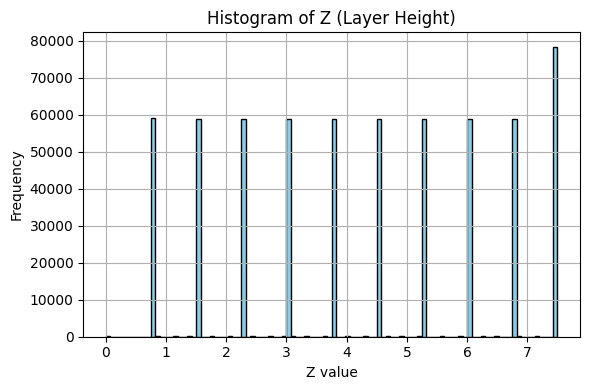

Total samples: 610615
Key Z values: 608093 (99.59%)
Other Z values: 2522 (0.41%)


In [36]:
# Z 컬럼의 고유한 값들 확인 (정렬 포함)
unique_z_values = sorted(df_all['Z'].unique())
print(unique_z_values)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df_all['Z'], bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Z value')
plt.ylabel('Frequency')
plt.title('Histogram of Z (Layer Height)')
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 조건별 개수 계산
is_key = df_all['Z'].isin(key_z_values)
n_key = is_key.sum()
n_total = len(df_all)
n_other = n_total - n_key

# 비율 출력
print(f"Total samples: {n_total}")
print(f"Key Z values: {n_key} ({n_key / n_total:.2%})")
print(f"Other Z values: {n_other} ({n_other / n_total:.2%})")

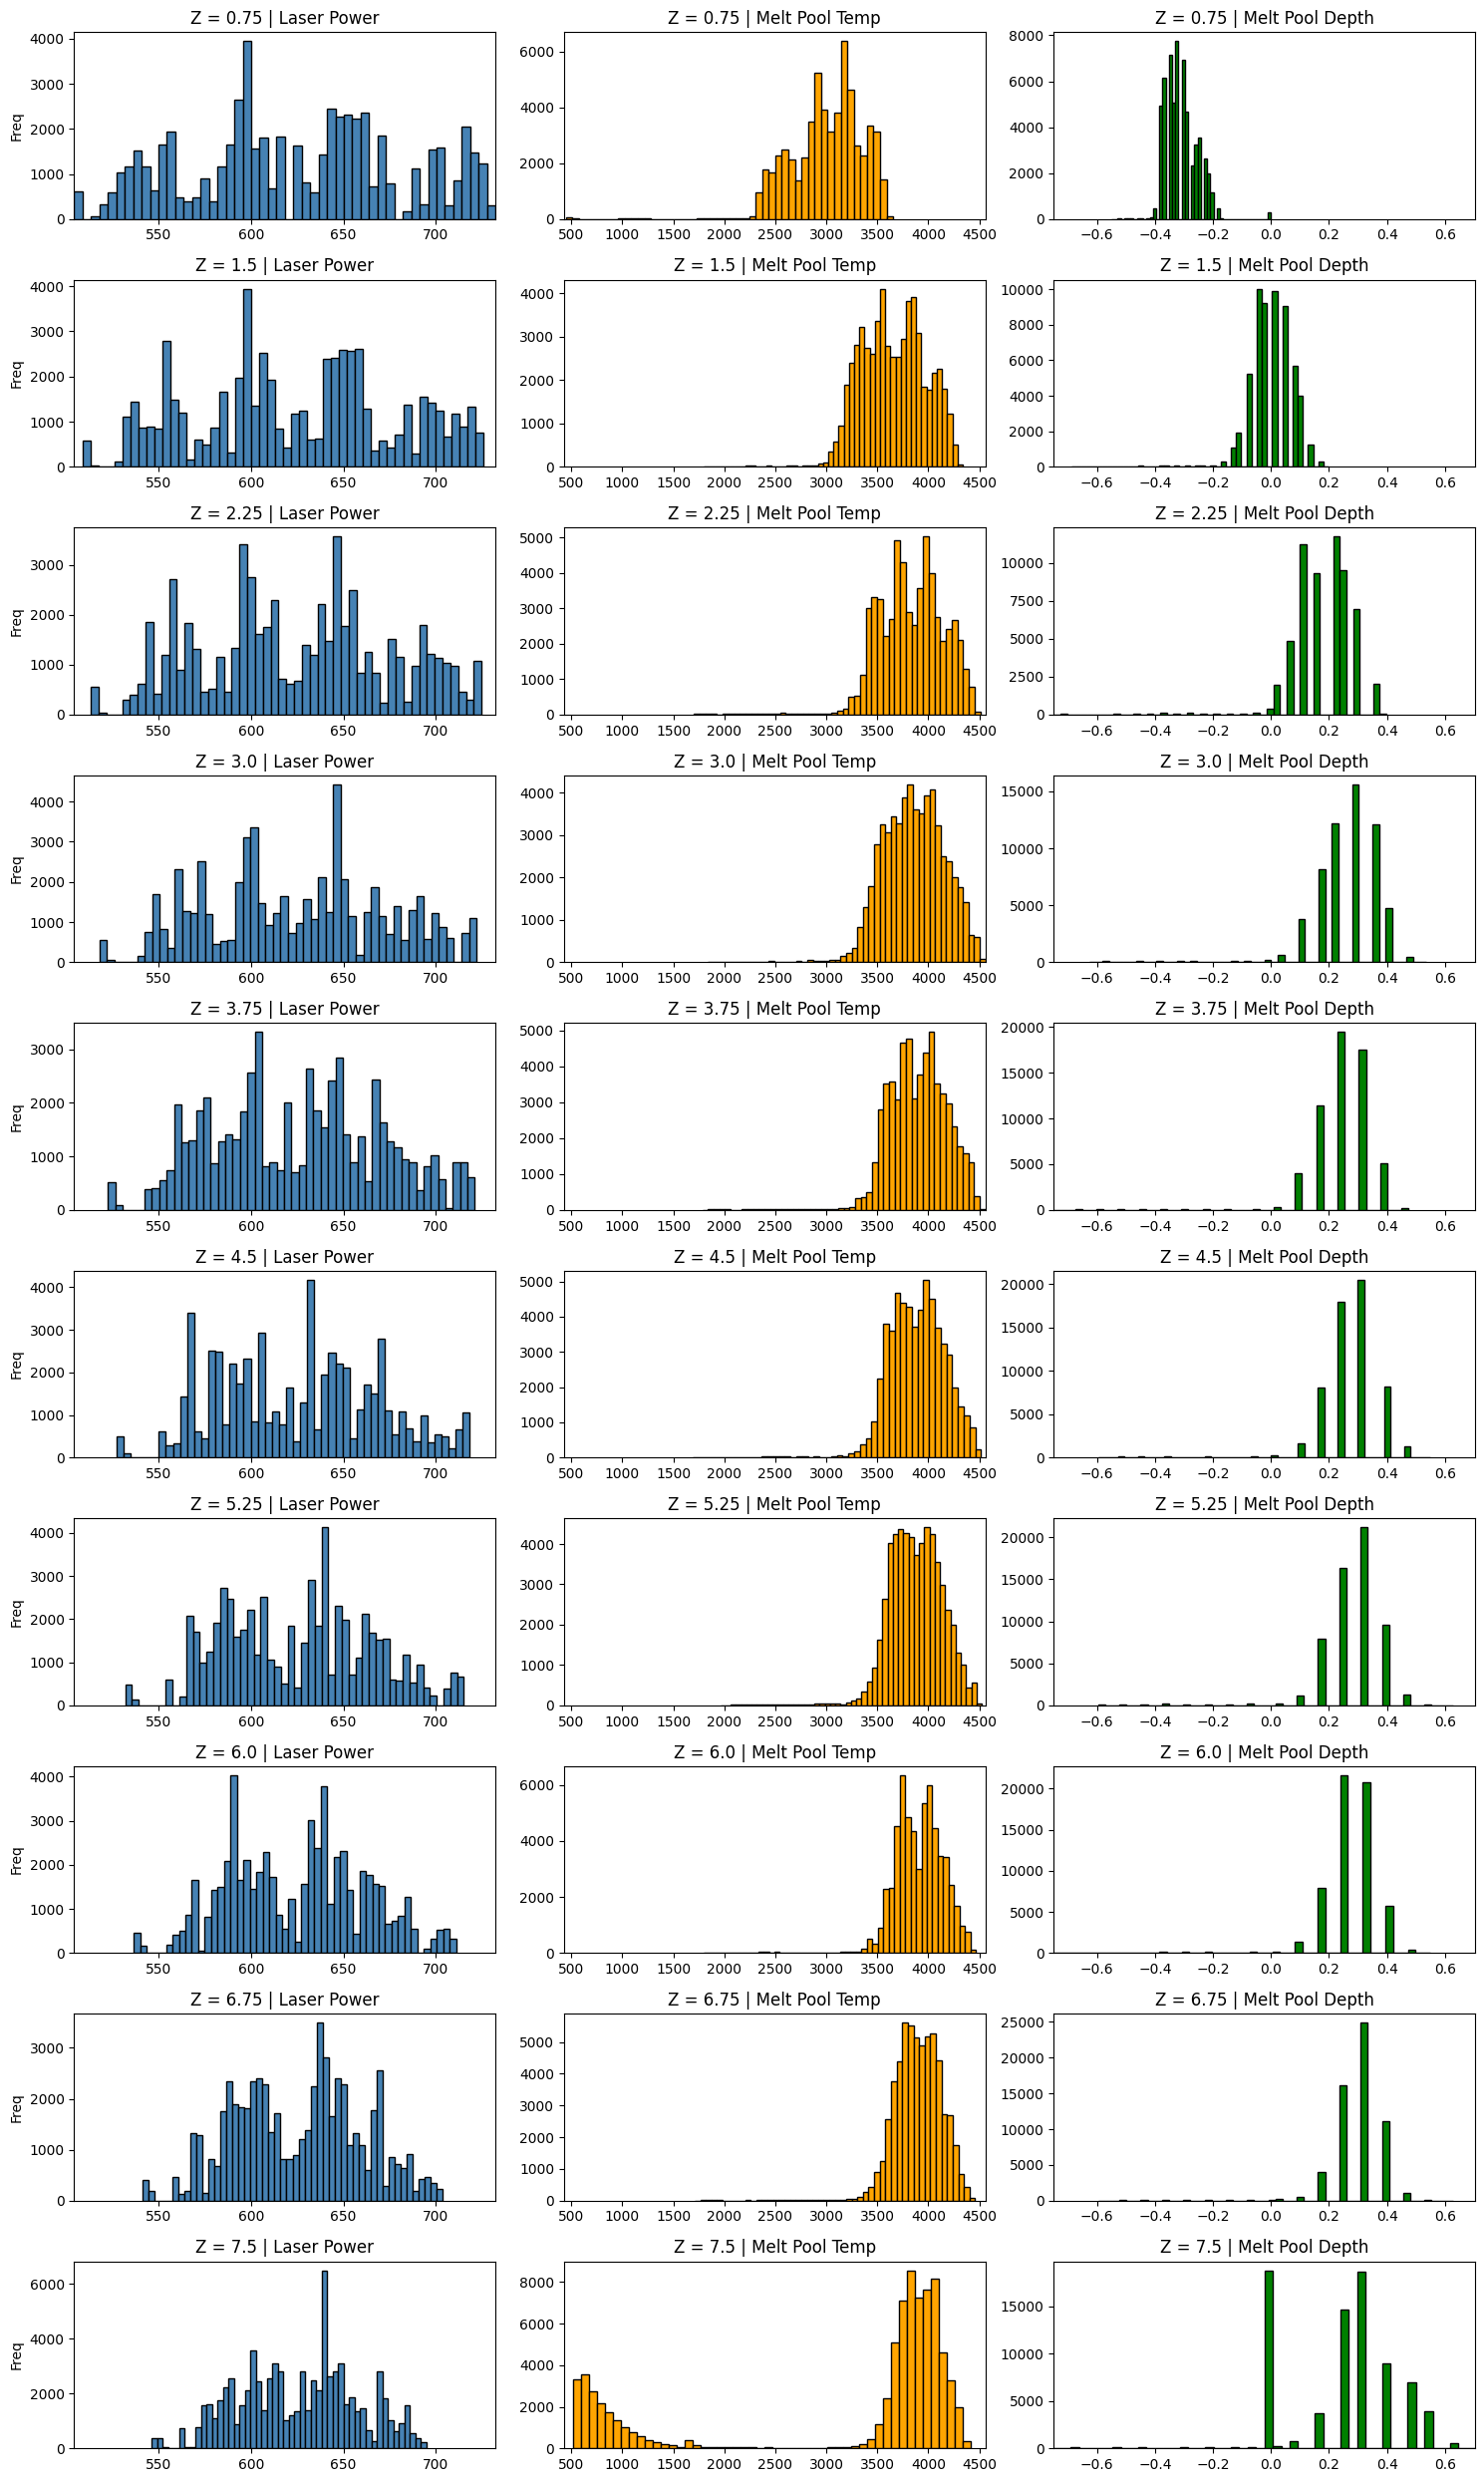

In [37]:
import matplotlib.pyplot as plt

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 각 변수별로 전체 데이터에서 공통 축 범위 구하기
xlims = {
    'Laser_power': (df_all['Laser_power'].min(), df_all['Laser_power'].max()),
    'melt_pool_temperature': (df_all['melt_pool_temperature'].min(), df_all['melt_pool_temperature'].max()),
    'melt_pool_depth': (df_all['melt_pool_depth'].min(), df_all['melt_pool_depth'].max())
}

# subplot 구조: n행 × 3열
n = len(key_z_values)
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, n * 2.5), sharex=False)

for i, z_val in enumerate(key_z_values):
    subset = df_all[df_all['Z'] == z_val]

    # (1) Laser_power
    axes[i, 0].hist(subset['Laser_power'], bins=50, color='steelblue', edgecolor='black')
    axes[i, 0].set_title(f'Z = {z_val} | Laser Power')
    axes[i, 0].set_xlim(xlims['Laser_power'])
    axes[i, 0].set_ylabel('Freq')

    # (2) melt_pool_temperature
    axes[i, 1].hist(subset['melt_pool_temperature'], bins=50, color='orange', edgecolor='black')
    axes[i, 1].set_title(f'Z = {z_val} | Melt Pool Temp')
    axes[i, 1].set_xlim(xlims['melt_pool_temperature'])

    # (3) melt_pool_depth
    axes[i, 2].hist(subset['melt_pool_depth'], bins=50, color='green', edgecolor='black')
    axes[i, 2].set_title(f'Z = {z_val} | Melt Pool Depth')
    axes[i, 2].set_xlim(xlims['melt_pool_depth'])

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()


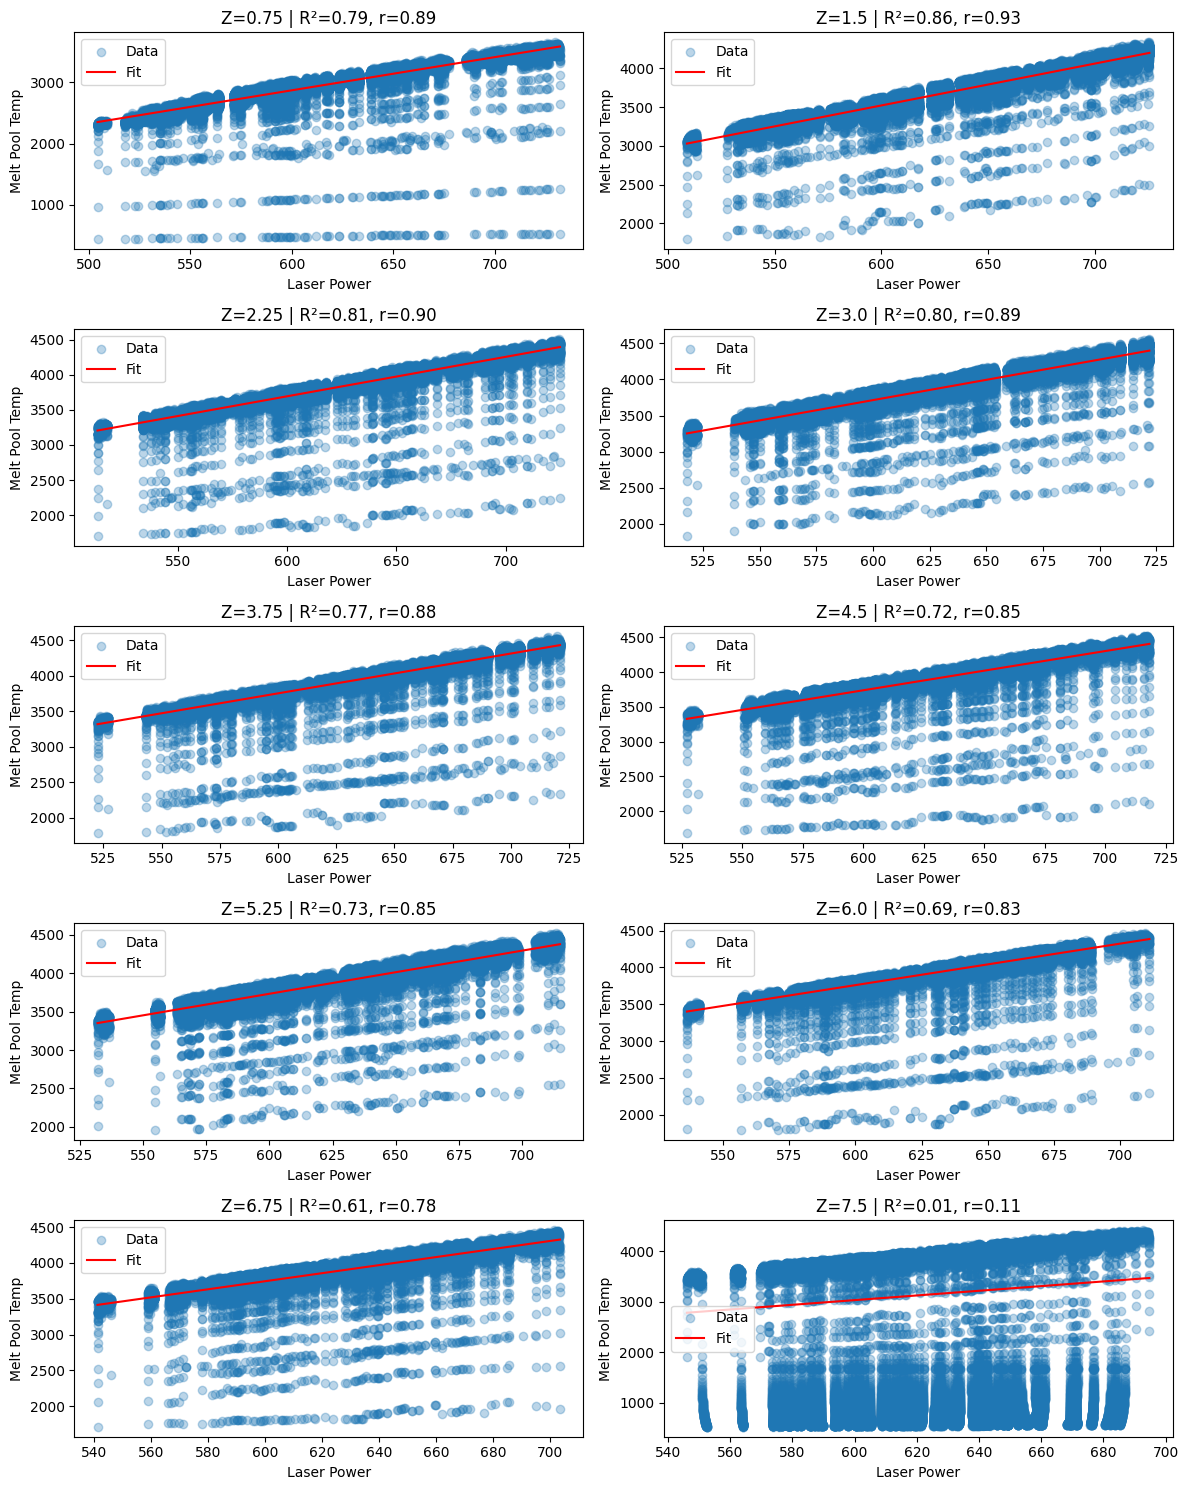

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

results = []

# subplot 설정 (2열 구조)
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)  # axes indexing robustness

plot_idx = 0  # 실제 그려진 subplot 수

for z_val in key_z_values:
    # Z별 subset 및 NaN 제거
    subset = df_all[df_all['Z'] == z_val][['Laser_power', 'melt_pool_temperature']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data after NaN removal, skipped.")
        continue

    # 상관계수
    pearson_r, pearson_p = pearsonr(subset['Laser_power'], subset['melt_pool_temperature'])
    spearman_r, spearman_p = spearmanr(subset['Laser_power'], subset['melt_pool_temperature'])

    # 선형 회귀
    X = subset[['Laser_power']].values
    y = subset['melt_pool_temperature'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_r': spearman_r,
        'Spearman_p': spearman_p,
        'Slope': slope,
        'Intercept': intercept,
        'R2': r2
    })

    # subplot 위치 계산
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    # 시각화
    ax.scatter(X, y, alpha=0.3, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_vals)
    ax.plot(x_vals, y_pred, color='red', label='Fit')
    ax.set_title(f'Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}')
    ax.set_xlabel('Laser Power')
    ax.set_ylabel('Melt Pool Temp')
    ax.legend()

# 빈 subplot 처리 (남는 칸 비우기)
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()




Selected laser_power_numbers: [73, 49, 54, 32, 94, 56, 93, 27, 65]


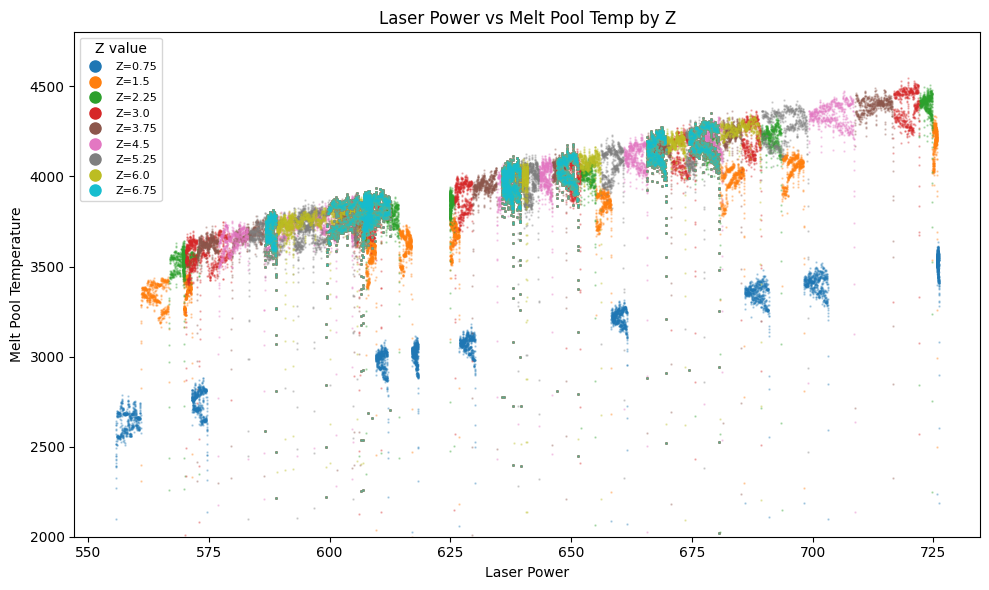

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.lines as mlines

import random

n = 9  # 선택할 개수
target_lasers = random.sample(range(2, 100), n)
print("Selected laser_power_numbers:", target_lasers)

#target_lasers = [10, 20, 30, 40, 50]
df_all_n = df_all[df_all['laser_power_number'].isin(target_lasers)]

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75]
results = []

# 색상 맵 설정
colors = cm.get_cmap('tab10', len(key_z_values))  # 또는 'viridis', 'plasma' 등 가능

# 전체 plot 하나만 생성
fig, ax = plt.subplots(figsize=(10, 6))

for idx, z_val in enumerate(key_z_values):
    # Z별 subset 및 NaN 제거
    subset = df_all_n[df_all_n['Z'] == z_val][['Laser_power', 'melt_pool_temperature']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data after NaN removal, skipped.")
        continue

    # 상관계수
    pearson_r, pearson_p = pearsonr(subset['Laser_power'], subset['melt_pool_temperature'])
    spearman_r, spearman_p = spearmanr(subset['Laser_power'], subset['melt_pool_temperature'])

    # 선형 회귀
    X = subset[['Laser_power']].values
    y = subset['melt_pool_temperature'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_r': spearman_r,
        'Spearman_p': spearman_p,
        'Slope': slope,
        'Intercept': intercept,
        'R2': r2
    })

    # 산점도 및 회귀선
    color = colors(idx)
    ax.scatter(X, y, s=0.5, alpha=0.3, label=f'Z={z_val}', color=color)
    # x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    # y_pred = model.predict(x_vals)
    # ax.plot(x_vals, y_pred, color=color, linewidth=1)

# scatter 저장하고 나중에 legend용으로 사용
scatter_handles = []

for idx, z_val in enumerate(key_z_values):
    # ...
    color = colors(idx)
    scatter = ax.scatter(X, y, s=1, alpha=0.3, color=color, label=f'Z={z_val}')
    
    # legend 표시용 handle 추가
    handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                           markersize=8, label=f'Z={z_val}')
    scatter_handles.append(handle)

# 범례 표시 (커진 점 포함)
ax.legend(handles=scatter_handles, title='Z value', fontsize=9)

# 라벨 및 범례
ax.set_title('Laser Power vs Melt Pool Temp by Z')
ax.set_xlabel('Laser Power')
ax.set_ylabel('Melt Pool Temperature')
ax.legend(handles=scatter_handles, title='Z value', fontsize=8)
ax.set_ylim(2000, 4800)
plt.tight_layout()
plt.show()


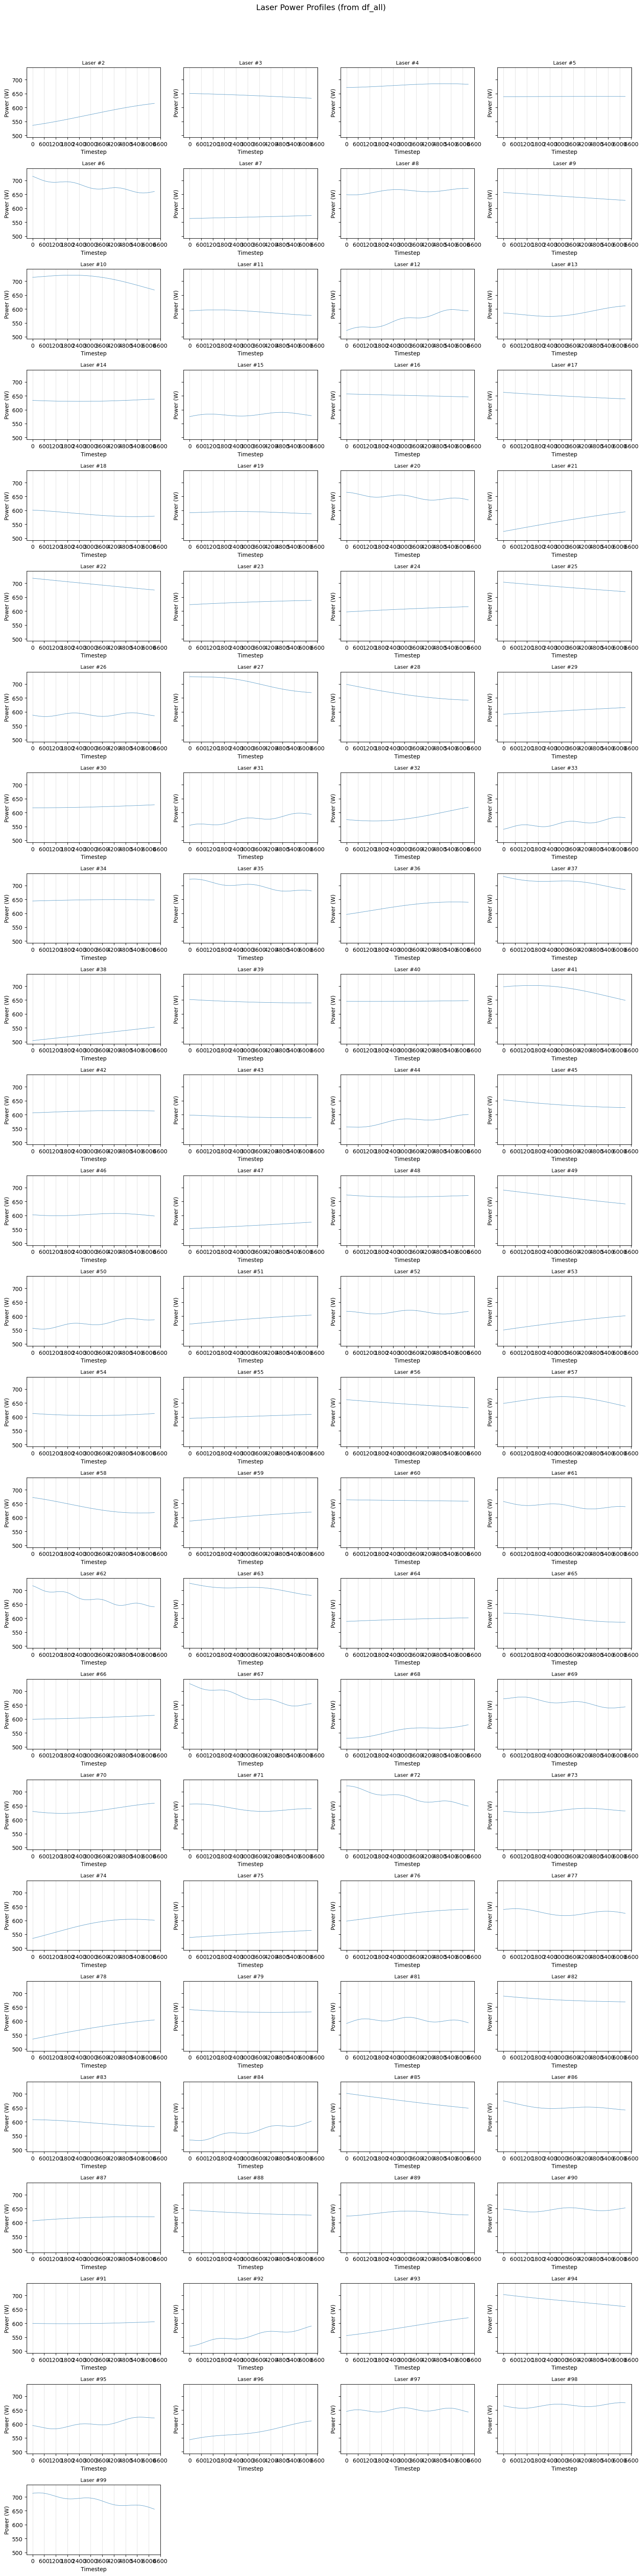

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MultipleLocator

# 1. 유효한 laser_power_number 목록 구하기
unique_lasers = sorted(df_all['laser_power_number'].dropna().unique().astype(int))

# 2. subplot 설정
n_cols = 4
n_plots = len(unique_lasers)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2.5), sharey=True)
axes = axes.flatten()

# 3. 각 laser_power_number에 대해 플롯
for i, laser_num in enumerate(unique_lasers):
    df_laser = df_all[df_all['laser_power_number'] == laser_num]
    laser_power = df_laser['Laser_power'].values

    ax = axes[i]
    ax.plot(laser_power, linewidth=0.5)
    ax.set_title(f"Laser #{laser_num}", fontsize=9)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Power (W)")
    ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.4)
    
    # 600 단위 x축 눈금 간격
    ax.xaxis.set_major_locator(MultipleLocator(600))

# 4. 빈 subplot 비우기
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# 5. 마무리
plt.tight_layout()
plt.suptitle("Laser Power Profiles (from df_all)", y=1.02, fontsize=14)
plt.show()


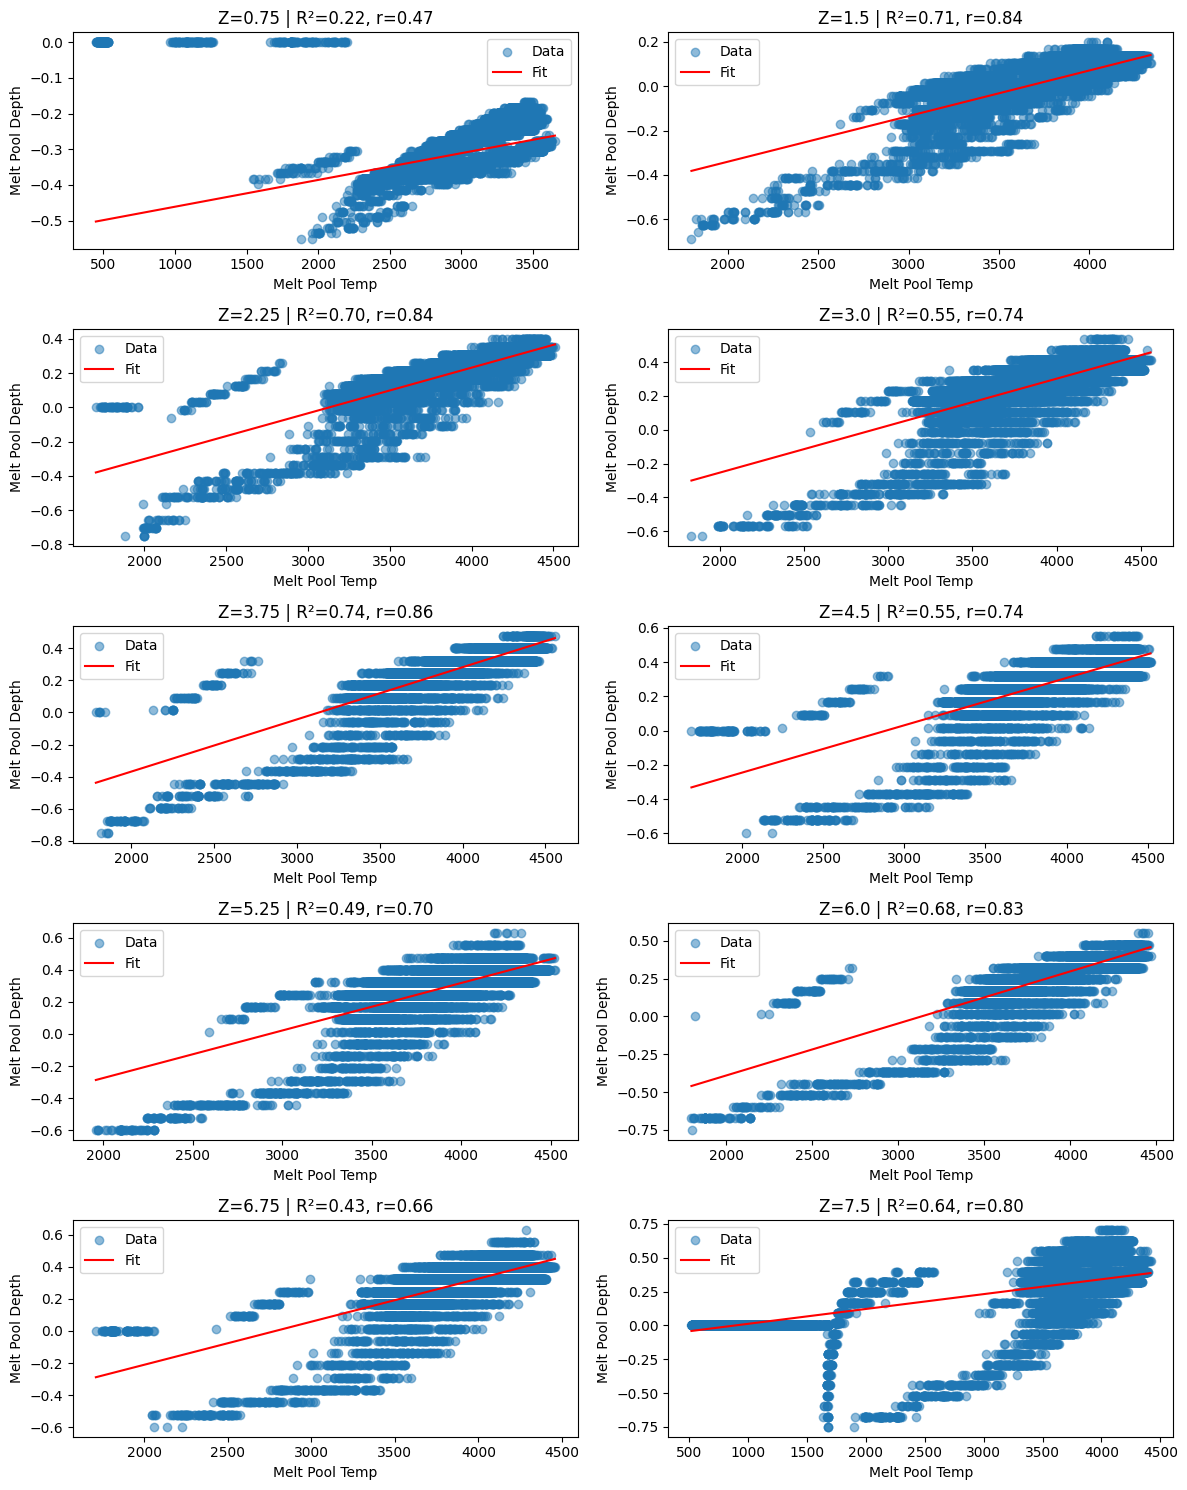

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

results = []

# subplot 설정 (2열)
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)

plot_idx = 0

for z_val in key_z_values:
    subset = df_all[df_all['Z'] == z_val][['melt_pool_temperature', 'melt_pool_depth']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data, skipped.")
        continue

    # 상관 분석 + 회귀
    pearson_r, _ = pearsonr(subset['melt_pool_temperature'], subset['melt_pool_depth'])
    X = subset[['melt_pool_temperature']].values
    y = subset['melt_pool_depth'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = model.coef_[0]

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Slope': slope,
        'R2': r2
    })

    # 시각화
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    ax.scatter(X, y, alpha=0.5, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_vals, model.predict(x_vals), color='red', label='Fit')
    ax.set_title(f"Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}")
    ax.set_xlabel("Melt Pool Temp")
    ax.set_ylabel("Melt Pool Depth")
    ax.legend()

# 빈 subplot 비우기
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()


